# Chapter 22 - The Transformer Model

## Listing 22-1. Import the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('hierarchical_sales_data.csv')

df_sum = df[['DATE']]

# Sum the sales and promos of the different products
df_sum['SALES'] = df[[x for x in df.columns if x.startswith('QTY')]].sum(axis=1)
df_sum['PROMO'] = df[[x for x in df.columns if x.startswith('PROMO')]].sum(axis=1)

# Create sum of sales and promos per month
df_sum['YEAR_MONTH'] = df_sum['DATE'].apply(lambda x: x[:7])
df_sum = df_sum[['SALES', 'PROMO', 'YEAR_MONTH']].groupby('YEAR_MONTH').sum()
df_sum.head()

# Preview the data
df_sum.head()


/var/folders/5z/nxlf2r4n5yx6qy1wbzvkr3xr0000gn/T/ipykernel_74850/896776394.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sum['SALES'] = df[[x for x in df.columns if x.startswith('QTY')]].sum(axis=1)
/var/folders/5z/nxlf2r4n5yx6qy1wbzvkr3xr0000gn/T/ipykernel_74850/896776394.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sum['PROMO'] = df[[x for x in df.columns if x.startswith('PROMO')]].sum(axis=1)
/var/folders/5z/nxlf2r4n5yx6qy1wbzvkr3xr0000gn/T/ipykernel_74850/896776394.py:14: SettingWit

,SALES,PROMO
YEAR_MONTH,,
2014-01,12819,990
2014-02,17906,1329
2014-03,12047,896
2014-04,15998,1235
2014-05,17453,1354


## Listing 22-2. Prepare for Darts and create univariate train test split

In [2]:
import numpy as np
from darts.timeseries import TimeSeries

# Convert sales data to float32 for Darts
df_sum['SALES'] = df_sum['SALES'].map(np.float32)

# Convert the dataframe index to a datetime index as required by Darts
df_sum.index = pd.DatetimeIndex(df_sum.index)

# Full year 2014 to 2017 is the training data
train = df_sum.iloc[:-12]

# Full year 2018 is the test data
test = df_sum.iloc[-12:]

# Convert the training data to a Darts time series
train_series = TimeSeries.from_dataframe(train[['SALES']])

# Inspect the time series format
train_series

<TimeSeries (DataArray) (YEAR_MONTH: 48, component: 1, sample: 1)> Size: 192B
array([[[12819.]],

       [[17906.]],

       [[12047.]],

       [[15998.]],

       [[17453.]],

       [[17310.]],

       [[13523.]],

       [[13279.]],

       [[11887.]],

       [[18202.]],

...

       [[15957.]],

       [[13524.]],

       [[12601.]],

       [[13516.]],

       [[11642.]],

       [[ 8858.]],

       [[14215.]],

       [[11029.]],

       [[16095.]],

       [[13111.]]], dtype=float32)
Coordinates:
  * YEAR_MONTH  (YEAR_MONTH) datetime64[ns] 384B 2014-01-01 ... 2017-12-01
  * component   (component) <U5 20B 'SALES'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

## Listing 22-3. Scaling the data

In [3]:
# Scale the data based on the training data
from darts.dataprocessing.transformers import Scaler
my_scaler = Scaler()
train_scaled = my_scaler.fit_transform(train_series)
train_scaled


<TimeSeries (DataArray) (YEAR_MONTH: 48, component: 1, sample: 1)> Size: 192B
array([[[0.42390835]],

       [[0.9683219 ]],

       [[0.34128845]],

       [[0.76412666]],

       [[0.9198415 ]],

       [[0.9045377 ]],

       [[0.49925077]],

       [[0.47313786]],

       [[0.32416523]],

       [[1.        ]],

...

       [[0.7597388 ]],

       [[0.49935782]],

       [[0.4005779 ]],

       [[0.49850166]],

       [[0.29794514]],

       [[0.        ]],

       [[0.57330906]],

       [[0.23234153]],

       [[0.77450764]],

       [[0.45515835]]], dtype=float32)
Coordinates:
  * YEAR_MONTH  (YEAR_MONTH) datetime64[ns] 384B 2014-01-01 ... 2017-12-01
  * component   (component) <U5 20B 'SALES'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

## Listing 22-4. Create default model

In [4]:
# Use MLFlow autologging for Darts
import mlflow
mlflow.autolog()

# import the TransformerModel
from darts.models import TransformerModel

# Specifying a default model
model = TransformerModel(
    # with input chunck length 24 (number of time steps used as input)
    input_chunk_length=24,
    # with output chunck 12 (number of time steps used as output)
    output_chunk_length=12,
    n_epochs=20,
    random_state=123
)

# Train the model
model.fit(train_scaled)

2025/06/12 15:57:40 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/06/12 15:57:40 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/06/12 15:57:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for pytorch_lightning.
/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025/06/12 15:57:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU ava

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, train_loss=0.459]

2025/06/12 15:57:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s, train_loss=0.437]

2025/06/12 15:57:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 19.40it/s, train_loss=0.164]

2025/06/12 15:57:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 19.89it/s, train_loss=0.145]

2025/06/12 15:57:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 19.58it/s, train_loss=0.114]

2025/06/12 15:57:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 19.33it/s, train_loss=0.0918]

2025/06/12 15:57:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 20.11it/s, train_loss=0.0903]

2025/06/12 15:57:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 19.24it/s, train_loss=0.0947]

2025/06/12 15:57:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 19.95it/s, train_loss=0.0946]

2025/06/12 15:57:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 19.43it/s, train_loss=0.0896]

2025/06/12 15:57:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 19.19it/s, train_loss=0.0818]

2025/06/12 15:57:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 20.15it/s, train_loss=0.0785]

2025/06/12 15:57:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 20.44it/s, train_loss=0.0655]

2025/06/12 15:57:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 19.28it/s, train_loss=0.0683]

2025/06/12 15:57:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 19.21it/s, train_loss=0.0798]

2025/06/12 15:57:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 19.65it/s, train_loss=0.0633]

2025/06/12 15:57:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 20.37it/s, train_loss=0.0722]

2025/06/12 15:57:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 20.06it/s, train_loss=0.0773]

2025/06/12 15:57:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 19.33it/s, train_loss=0.0708]

2025/06/12 15:57:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 19.86it/s, train_loss=0.0701]

2025/06/12 15:57:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 19.03it/s, train_loss=0.0701]


2025/06/12 15:57:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


TransformerModel(output_chunk_shift=0, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=24, output_chunk_length=12, n_epochs=20, random_state=123)

## Listing 22-5. Build the forecast and analyze results

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]
0.7827418893575668


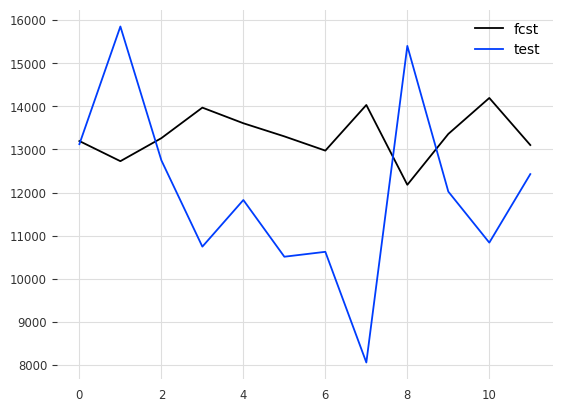

In [5]:
from sklearn.metrics import mean_absolute_percentage_error

# Forecast 12 steps using this model
fcst = model.predict(12)

# Rescale the predictions to the original scale
fcst = my_scaler.inverse_transform(fcst).values()

# Compute metric
metric = 1 - mean_absolute_percentage_error(list(test['SALES']), fcst)
print(metric)

plt.plot(fcst)
plt.plot(list(test['SALES']))
plt.legend(['fcst', 'test'])

## Listing 22-6. Create multivariate train test split (future promos not possible)

In [8]:
df_sum['PROMO'] = df_sum['PROMO'].map(np.float32)

# Convert the training data to a Darts time series
promos_train = TimeSeries.from_dataframe(train[['PROMO']])

# Convert to float32 for Darts
promos_train = promos_train.astype(np.float32)

promo_scaler = Scaler()
promos_train = promo_scaler.fit_transform(promos_train)
promos_train

<TimeSeries (DataArray) (YEAR_MONTH: 48, component: 1, sample: 1)> Size: 192B
array([[[0.08514488]],

       [[0.39221013]],

       [[0.        ]],

       [[0.30706525]],

       [[0.414855  ]],

       [[0.46014488]],

       [[0.29981887]],

       [[1.        ]],

       [[0.07699275]],

       [[0.384058  ]],

...

       [[0.41123188]],

       [[0.37862313]],

       [[0.4574275 ]],

       [[0.35144925]],

       [[0.6277174 ]],

       [[0.24818838]],

       [[0.6123189 ]],

       [[0.49456525]],

       [[0.5942029 ]],

       [[0.5742754 ]]], dtype=float32)
Coordinates:
  * YEAR_MONTH  (YEAR_MONTH) datetime64[ns] 384B 2014-01-01 ... 2017-12-01
  * component   (component) <U5 20B 'PROMO'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

## Listing 22-7 Create multivariate model

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 16:06:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '12e3ac97729f464c9665a7786c3c724c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 15.15it/s, train_loss=0.689]

2025/06/12 16:06:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s, train_loss=0.493]

2025/06/12 16:06:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s, train_loss=0.210]

2025/06/12 16:06:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s, train_loss=0.136]

2025/06/12 16:06:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s, train_loss=0.0828]

2025/06/12 16:06:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s, train_loss=0.0801]

2025/06/12 16:06:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s, train_loss=0.0878]

2025/06/12 16:06:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s, train_loss=0.0903]

2025/06/12 16:06:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s, train_loss=0.0887]

2025/06/12 16:06:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s, train_loss=0.100] 

2025/06/12 16:06:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s, train_loss=0.0834]

2025/06/12 16:06:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s, train_loss=0.0716]

2025/06/12 16:06:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s, train_loss=0.0589]

2025/06/12 16:06:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s, train_loss=0.0763]

2025/06/12 16:06:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s, train_loss=0.0594]

2025/06/12 16:06:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s, train_loss=0.0541]

2025/06/12 16:06:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s, train_loss=0.0739]

2025/06/12 16:06:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s, train_loss=0.0728]

2025/06/12 16:06:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s, train_loss=0.0665]

2025/06/12 16:06:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s, train_loss=0.0646]

2025/06/12 16:06:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s, train_loss=0.0646]


2025/06/12 16:06:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.49it/s]
0.8098367005586624


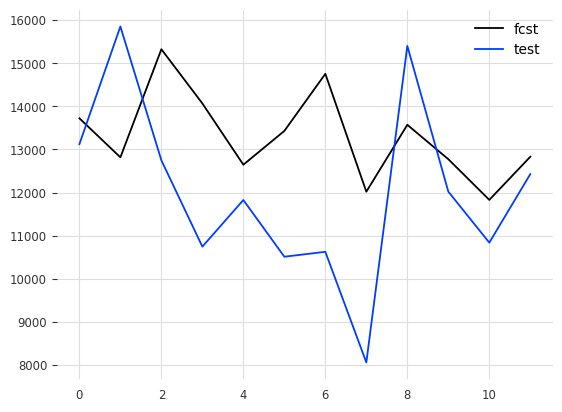

In [10]:
# Specifying a default model
model = TransformerModel(
    # with input chunck length 24 (number of time steps used as input)
    input_chunk_length=24,
    # with output chunck 12 (number of time steps used as output)
    output_chunk_length=12,
    n_epochs=20,
    random_state=123   
)

# Train the model
model.fit(
    train_scaled,
    
    # add the promotions as past covariates
    past_covariates=promos_train
)


# Forecast 12 steps using this model
fcst = model.predict(
    n=12,

    # add past covariates (promos train)
    past_covariates=promos_train,
)


# Rescale the predictions to the original scale
fcst = my_scaler.inverse_transform(fcst).values()

# Compute metric
metric = 1 - mean_absolute_percentage_error(list(test['SALES']), fcst)
print(metric)

plt.plot(fcst)
plt.plot(list(test['SALES']))
plt.legend(['fcst', 'test'])

## Listing 22-8. Tune multivariate model hyperparameters and analyze

In [17]:
def score_nbeats(input_chunck_length, n_epochs, d_model, nhead, num_encoder_layers, num_decoder_layers):
    
    # Specifying a model using the gridsearch parameters
    model = TransformerModel(
        input_chunk_length=input_chunck_length,
        output_chunk_length=12,
        n_epochs=n_epochs,
        d_model=d_model, 
        nhead=nhead,
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        random_state=123
    )
    
    # Train the model
    model.fit(
        train_scaled,
        
        # add the promotions as past covariates
        past_covariates=promos_train
    )
    
    
    # Forecast 12 steps using this model
    fcst = model.predict(
        n=12,
    
        # add past covariates (promos train)
        past_covariates=promos_train,
        
    )

    # Rescale the predictions to the original scale
    fcst = my_scaler.inverse_transform(fcst).values()
    
    # Compute metric
    metric = 1 - mean_absolute_percentage_error(list(test['SALES']), fcst)

    return metric



#d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3

# Run a Grid Search
grid_result = []
for input_chunck_length in [12, 24]:
    for n_epochs in [5, 10]:
        for d_model in [32, 64]:
            for nhead in [4, 8]:
                for num_encoder_layers in [2, 3, 4]:
                    for num_decoder_layers in [3, 4]:
                        score = score_nbeats(input_chunck_length, n_epochs, d_model, nhead, num_encoder_layers, num_decoder_layers)
                        result = [input_chunck_length, n_epochs, d_model, nhead, num_encoder_layers, num_decoder_layers, score]
                        grid_result.append(result)


# Inspect the results in a DataFrame
grid_output = pd.DataFrame(grid_result, columns=[
    'input_chunck_length',
    'n_epochs', 
    'd_model', 
    'nhead', 
    'num_encoder_layers', 
    'num_decoder_layers', 
    'score'
])

grid_output.sort_values('score', ascending=False).head()
                                 

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:13:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '173f42e085874bc7a4b51770814e6c07', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s, train_loss=0.666]

2025/06/12 17:13:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s, train_loss=0.343]

2025/06/12 17:13:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s, train_loss=0.174]

2025/06/12 17:13:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s, train_loss=0.155]

2025/06/12 17:13:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 18.49it/s, train_loss=0.141]

2025/06/12 17:13:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s, train_loss=0.141]


2025/06/12 17:13:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.48it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:13:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ad67763ab7b74435ab3b458d57b047ab', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.69it/s, train_loss=1.030]

2025/06/12 17:13:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.91it/s, train_loss=0.329]

2025/06/12 17:13:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 16.32it/s, train_loss=0.202]

2025/06/12 17:13:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s, train_loss=0.125]

2025/06/12 17:13:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.93it/s, train_loss=0.0905]

2025/06/12 17:13:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.31it/s, train_loss=0.0905]


2025/06/12 17:13:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.93it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:13:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b135b622acc443c2a417f69967840244', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 15.10it/s, train_loss=0.886]

2025/06/12 17:13:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 16.38it/s, train_loss=0.352]

2025/06/12 17:13:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 16.56it/s, train_loss=0.168]

2025/06/12 17:13:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 16.17it/s, train_loss=0.109]

2025/06/12 17:13:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.59it/s, train_loss=0.112]

2025/06/12 17:13:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.87it/s, train_loss=0.112]


2025/06/12 17:13:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.30it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:13:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1611574821fc4ffdbe2b4f49ed4322e7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s, train_loss=0.738]

2025/06/12 17:13:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 13.57it/s, train_loss=0.290]

2025/06/12 17:13:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s, train_loss=0.212]

2025/06/12 17:13:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 14.32it/s, train_loss=0.155]

2025/06/12 17:13:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.97it/s, train_loss=0.113]

2025/06/12 17:13:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.39it/s, train_loss=0.113]


2025/06/12 17:13:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.63it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:13:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '06191f84b5b747a6af9b8c8b8a75de3f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s, train_loss=0.463]

2025/06/12 17:13:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 15.64it/s, train_loss=0.258]

2025/06/12 17:13:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 14.80it/s, train_loss=0.169]

2025/06/12 17:13:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 14.99it/s, train_loss=0.125]

2025/06/12 17:13:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s, train_loss=0.113]

2025/06/12 17:13:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.28it/s, train_loss=0.113]


2025/06/12 17:13:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.08it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:13:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '65ac61ce637b4d158057fd979ba5ef38', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s, train_loss=0.504]

2025/06/12 17:13:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s, train_loss=0.266]

2025/06/12 17:13:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s, train_loss=0.148]

2025/06/12 17:13:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 13.62it/s, train_loss=0.121]

2025/06/12 17:13:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.37it/s, train_loss=0.109]

2025/06/12 17:13:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s, train_loss=0.109]


2025/06/12 17:13:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.12it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:13:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4bd5ebb4c6774b8aa2cb6557c89c016f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s, train_loss=0.666]

2025/06/12 17:13:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 19.59it/s, train_loss=0.334]

2025/06/12 17:13:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s, train_loss=0.177]

2025/06/12 17:13:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 19.22it/s, train_loss=0.141]

2025/06/12 17:13:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 18.90it/s, train_loss=0.137]

2025/06/12 17:13:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s, train_loss=0.137]


2025/06/12 17:13:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.03it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:13:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '60c85995409d4239a8af2913cf489667', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 16.59it/s, train_loss=0.996]

2025/06/12 17:13:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 16.14it/s, train_loss=0.335]

2025/06/12 17:13:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s, train_loss=0.204]

2025/06/12 17:13:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 16.84it/s, train_loss=0.126]

2025/06/12 17:13:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s, train_loss=0.0851]

2025/06/12 17:13:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s, train_loss=0.0851]


2025/06/12 17:13:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.34it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:13:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c90f7d6156a94e2fa6a08d72581f0e22', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s, train_loss=0.869]

2025/06/12 17:13:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 16.51it/s, train_loss=0.345]

2025/06/12 17:13:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 16.31it/s, train_loss=0.163]

2025/06/12 17:13:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 16.38it/s, train_loss=0.113]

2025/06/12 17:13:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.95it/s, train_loss=0.115]

2025/06/12 17:13:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.23it/s, train_loss=0.115]


2025/06/12 17:13:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.71it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:13:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '29ed7be1e3f64a1c9642c86e532b4345', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s, train_loss=0.787]

2025/06/12 17:13:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.60it/s, train_loss=0.284]

2025/06/12 17:13:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 15.24it/s, train_loss=0.211]

2025/06/12 17:13:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 14.72it/s, train_loss=0.160]

2025/06/12 17:13:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.42it/s, train_loss=0.118]

2025/06/12 17:13:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.90it/s, train_loss=0.118]


2025/06/12 17:13:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.67it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:13:44 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a9c1d209e98f4b298c2a3e23cda04cc8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.32it/s, train_loss=0.444]

2025/06/12 17:13:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 16.05it/s, train_loss=0.269]

2025/06/12 17:13:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 15.55it/s, train_loss=0.167]

2025/06/12 17:13:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.16it/s, train_loss=0.131]

2025/06/12 17:13:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.20it/s, train_loss=0.125]

2025/06/12 17:13:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.52it/s, train_loss=0.125]


2025/06/12 17:13:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.05it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:13:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '712606a1f3a941e9b54d41a2e8ea1d0a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s, train_loss=0.577]

2025/06/12 17:13:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 13.25it/s, train_loss=0.253]

2025/06/12 17:13:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 13.66it/s, train_loss=0.140]

2025/06/12 17:13:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 14.05it/s, train_loss=0.117]

2025/06/12 17:13:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s, train_loss=0.110]

2025/06/12 17:13:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s, train_loss=0.110]


2025/06/12 17:13:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.80it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:13:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ca27bd33280e4fd0954c00e185711e81', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s, train_loss=0.457]

2025/06/12 17:13:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 19.92it/s, train_loss=0.333]

2025/06/12 17:13:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 19.96it/s, train_loss=0.157]

2025/06/12 17:13:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 19.96it/s, train_loss=0.109]

2025/06/12 17:13:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 19.46it/s, train_loss=0.0958]

2025/06/12 17:13:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s, train_loss=0.0958]


2025/06/12 17:13:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.79it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:13:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f4f5d3ecb9ff4048b33ed0d6276c56a4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.52it/s, train_loss=0.752]

2025/06/12 17:13:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 16.41it/s, train_loss=0.558]

2025/06/12 17:13:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 16.25it/s, train_loss=0.247]

2025/06/12 17:13:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s, train_loss=0.123]

2025/06/12 17:13:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.79it/s, train_loss=0.116]

2025/06/12 17:13:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.03it/s, train_loss=0.116]


2025/06/12 17:14:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.05it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:14:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1333aaf4e34045b9ab98c593f69f7e7c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 15.66it/s, train_loss=0.773]

2025/06/12 17:14:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 16.80it/s, train_loss=0.454]

2025/06/12 17:14:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s, train_loss=0.204]

2025/06/12 17:14:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s, train_loss=0.122]

2025/06/12 17:14:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s, train_loss=0.116]

2025/06/12 17:14:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.49it/s, train_loss=0.116]


2025/06/12 17:14:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.77it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:14:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '978dd9b79b39430da3d9000f784d7dff', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s, train_loss=0.729]

2025/06/12 17:14:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.76it/s, train_loss=0.258]

2025/06/12 17:14:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 14.83it/s, train_loss=0.140]

2025/06/12 17:14:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 14.74it/s, train_loss=0.121]

2025/06/12 17:14:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.95it/s, train_loss=0.105]

2025/06/12 17:14:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.43it/s, train_loss=0.105]


2025/06/12 17:14:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.64it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:14:09 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0482bb09993b4e25b1b522f5a5b59b22', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s, train_loss=0.749]

2025/06/12 17:14:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 15.99it/s, train_loss=0.287]

2025/06/12 17:14:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 16.07it/s, train_loss=0.196]

2025/06/12 17:14:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.53it/s, train_loss=0.124]

2025/06/12 17:14:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.24it/s, train_loss=0.106]

2025/06/12 17:14:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.60it/s, train_loss=0.106]


2025/06/12 17:14:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.55it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:14:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '64e9f32da5aa4af9925a855a851199ba', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s, train_loss=0.759]

2025/06/12 17:14:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 13.69it/s, train_loss=0.395]

2025/06/12 17:14:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 13.67it/s, train_loss=0.148]

2025/06/12 17:14:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 13.48it/s, train_loss=0.103]

2025/06/12 17:14:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.84it/s, train_loss=0.110]

2025/06/12 17:14:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s, train_loss=0.110]


2025/06/12 17:14:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.15it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:14:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b2f9c4ae4d484587938e5fa61eedeb71', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.01it/s, train_loss=0.456]

2025/06/12 17:14:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 19.82it/s, train_loss=0.345]

2025/06/12 17:14:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 19.92it/s, train_loss=0.155]

2025/06/12 17:14:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 19.19it/s, train_loss=0.107]

2025/06/12 17:14:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 19.51it/s, train_loss=0.0928]

2025/06/12 17:14:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 18.56it/s, train_loss=0.0928]


2025/06/12 17:14:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.80it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:14:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0a4f747022ae45f794d6b379bfb0c293', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 15.18it/s, train_loss=0.736]

2025/06/12 17:14:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 16.47it/s, train_loss=0.546]

2025/06/12 17:14:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 16.31it/s, train_loss=0.239]

2025/06/12 17:14:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 16.54it/s, train_loss=0.129]

2025/06/12 17:14:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s, train_loss=0.114]

2025/06/12 17:14:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.10it/s, train_loss=0.114]


2025/06/12 17:14:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.09it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:14:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f034aeb00c694020ac4958663388548a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 15.90it/s, train_loss=0.797]

2025/06/12 17:14:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 16.72it/s, train_loss=0.440]

2025/06/12 17:14:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s, train_loss=0.209]

2025/06/12 17:14:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s, train_loss=0.120]

2025/06/12 17:14:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s, train_loss=0.119]

2025/06/12 17:14:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.78it/s, train_loss=0.119]


2025/06/12 17:14:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.65it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:14:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fe893529f65d4523a43545e9d2d168ed', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.64it/s, train_loss=0.719]

2025/06/12 17:14:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 15.14it/s, train_loss=0.264]

2025/06/12 17:14:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 14.55it/s, train_loss=0.138]

2025/06/12 17:14:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.11it/s, train_loss=0.119]

2025/06/12 17:14:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.22it/s, train_loss=0.102]

2025/06/12 17:14:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.63it/s, train_loss=0.102]


2025/06/12 17:14:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.52it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:14:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'eafdc3d791524eb4ad8ad4e16db1a6ce', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.35it/s, train_loss=0.733]

2025/06/12 17:14:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 15.94it/s, train_loss=0.273]

2025/06/12 17:14:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 16.03it/s, train_loss=0.194]

2025/06/12 17:14:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.80it/s, train_loss=0.126]

2025/06/12 17:14:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.67it/s, train_loss=0.110]

2025/06/12 17:14:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.08it/s, train_loss=0.110]


2025/06/12 17:14:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.65it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:14:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '68aa674fb3d44ef7a4a0111315f7ac60', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.51it/s, train_loss=0.778]

2025/06/12 17:14:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.01it/s, train_loss=0.405]

2025/06/12 17:14:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s, train_loss=0.155]

2025/06/12 17:14:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 13.66it/s, train_loss=0.103]

2025/06/12 17:14:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.92it/s, train_loss=0.107]

2025/06/12 17:14:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.42it/s, train_loss=0.107]


2025/06/12 17:14:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.87it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:14:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8ab9fb6970f04b279744c843eb8830e0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s, train_loss=0.666]

2025/06/12 17:14:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s, train_loss=0.343]

2025/06/12 17:14:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s, train_loss=0.174]

2025/06/12 17:14:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 18.69it/s, train_loss=0.155]

2025/06/12 17:14:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 18.95it/s, train_loss=0.141]

2025/06/12 17:14:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s, train_loss=0.115]

2025/06/12 17:14:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s, train_loss=0.0923]

2025/06/12 17:14:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 19.29it/s, train_loss=0.0861]

2025/06/12 17:14:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 18.95it/s, train_loss=0.0857]

2025/06/12 17:14:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s, train_loss=0.0918]

2025/06/12 17:14:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s, train_loss=0.0918]


2025/06/12 17:14:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.56it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:14:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '79805ec6d2fc4269bab31e55e6bb67f9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.69it/s, train_loss=1.030]

2025/06/12 17:14:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 15.93it/s, train_loss=0.329]

2025/06/12 17:14:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 15.33it/s, train_loss=0.202]

2025/06/12 17:14:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.71it/s, train_loss=0.125]

2025/06/12 17:14:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.58it/s, train_loss=0.0905]

2025/06/12 17:14:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 16.29it/s, train_loss=0.0872]

2025/06/12 17:14:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 15.80it/s, train_loss=0.0951]

2025/06/12 17:14:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 15.90it/s, train_loss=0.0974]

2025/06/12 17:14:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 16.35it/s, train_loss=0.0898]

2025/06/12 17:14:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 16.49it/s, train_loss=0.0914]

2025/06/12 17:14:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 15.71it/s, train_loss=0.0914]


2025/06/12 17:14:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.34it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:14:51 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '45e933e4c5fc4f74b0dd270a01b8503f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 15.07it/s, train_loss=0.886]

2025/06/12 17:14:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s, train_loss=0.352]

2025/06/12 17:14:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 16.69it/s, train_loss=0.168]

2025/06/12 17:14:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 16.41it/s, train_loss=0.109]

2025/06/12 17:14:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s, train_loss=0.112]

2025/06/12 17:14:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 16.83it/s, train_loss=0.0958]

2025/06/12 17:14:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 15.90it/s, train_loss=0.108] 

2025/06/12 17:14:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 16.78it/s, train_loss=0.0938]

2025/06/12 17:14:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 16.40it/s, train_loss=0.0906]

2025/06/12 17:14:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s, train_loss=0.0881]

2025/06/12 17:14:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 16.25it/s, train_loss=0.0881]


2025/06/12 17:14:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.84it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:14:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '319f43aa963340af8f26acbfd0f631cb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s, train_loss=0.738]

2025/06/12 17:14:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s, train_loss=0.290]

2025/06/12 17:14:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 15.19it/s, train_loss=0.212]

2025/06/12 17:14:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.23it/s, train_loss=0.155]

2025/06/12 17:14:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.22it/s, train_loss=0.113]

2025/06/12 17:14:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 14.57it/s, train_loss=0.090]

2025/06/12 17:14:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 14.63it/s, train_loss=0.0865]

2025/06/12 17:14:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 15.22it/s, train_loss=0.0945]

2025/06/12 17:14:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 14.30it/s, train_loss=0.0856]

2025/06/12 17:14:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 15.19it/s, train_loss=0.0924]

2025/06/12 17:14:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.59it/s, train_loss=0.0924]


2025/06/12 17:15:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.66it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:15:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8758351dec38487b9fee3941e518b840', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.71it/s, train_loss=0.463]

2025/06/12 17:15:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.94it/s, train_loss=0.258]

2025/06/12 17:15:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 15.24it/s, train_loss=0.169]

2025/06/12 17:15:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.32it/s, train_loss=0.125]

2025/06/12 17:15:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.58it/s, train_loss=0.113]

2025/06/12 17:15:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 15.35it/s, train_loss=0.0958]

2025/06/12 17:15:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 15.56it/s, train_loss=0.0989]

2025/06/12 17:15:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 15.83it/s, train_loss=0.0926]

2025/06/12 17:15:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 15.98it/s, train_loss=0.0958]

2025/06/12 17:15:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 15.43it/s, train_loss=0.0842]

2025/06/12 17:15:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.84it/s, train_loss=0.0842]


2025/06/12 17:15:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.61it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:15:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7d563cc33d0d4e85ae3180ef12049abf', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s, train_loss=0.504]

2025/06/12 17:15:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 13.92it/s, train_loss=0.266]

2025/06/12 17:15:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 13.61it/s, train_loss=0.148]

2025/06/12 17:15:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 13.61it/s, train_loss=0.121]

2025/06/12 17:15:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.52it/s, train_loss=0.109]

2025/06/12 17:15:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 13.97it/s, train_loss=0.106]

2025/06/12 17:15:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 13.94it/s, train_loss=0.089]

2025/06/12 17:15:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 13.40it/s, train_loss=0.0856]

2025/06/12 17:15:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s, train_loss=0.0861]

2025/06/12 17:15:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 13.88it/s, train_loss=0.0861]

2025/06/12 17:15:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s, train_loss=0.0861]


2025/06/12 17:15:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.59it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:15:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b4144585e8124dc2912fc8beceef27bd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.50it/s, train_loss=0.666]

2025/06/12 17:15:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s, train_loss=0.334]

2025/06/12 17:15:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s, train_loss=0.177]

2025/06/12 17:15:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s, train_loss=0.141]

2025/06/12 17:15:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 18.64it/s, train_loss=0.137]

2025/06/12 17:15:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s, train_loss=0.109]

2025/06/12 17:15:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s, train_loss=0.0889]

2025/06/12 17:15:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s, train_loss=0.0819]

2025/06/12 17:15:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s, train_loss=0.0862]

2025/06/12 17:15:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s, train_loss=0.0907]

2025/06/12 17:15:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s, train_loss=0.0907]


2025/06/12 17:15:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.20it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:15:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ac6c398dc3f349479819c3e03032e1c7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.02it/s, train_loss=0.996]

2025/06/12 17:15:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 15.58it/s, train_loss=0.335]

2025/06/12 17:15:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 15.39it/s, train_loss=0.204]

2025/06/12 17:15:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.77it/s, train_loss=0.126]

2025/06/12 17:15:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.44it/s, train_loss=0.0851]

2025/06/12 17:15:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 15.82it/s, train_loss=0.090] 

2025/06/12 17:15:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 15.62it/s, train_loss=0.0967]

2025/06/12 17:15:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 15.15it/s, train_loss=0.101] 

2025/06/12 17:15:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 14.58it/s, train_loss=0.0909]

2025/06/12 17:15:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 15.70it/s, train_loss=0.0881]

2025/06/12 17:15:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 15.07it/s, train_loss=0.0881]


2025/06/12 17:15:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.89it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:15:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3d447ced6eec4cbba9f975c84af40e1e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.37it/s, train_loss=0.869]

2025/06/12 17:15:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 16.41it/s, train_loss=0.345]

2025/06/12 17:15:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 16.77it/s, train_loss=0.163]

2025/06/12 17:15:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.70it/s, train_loss=0.113]

2025/06/12 17:15:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.11it/s, train_loss=0.115]

2025/06/12 17:15:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s, train_loss=0.0925]

2025/06/12 17:15:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 15.10it/s, train_loss=0.104] 

2025/06/12 17:15:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 16.01it/s, train_loss=0.0977]

2025/06/12 17:15:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 16.62it/s, train_loss=0.0937]

2025/06/12 17:15:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 16.68it/s, train_loss=0.0885]

2025/06/12 17:15:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 15.90it/s, train_loss=0.0885]


2025/06/12 17:15:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.45it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:15:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '52680f5059774dd3867e3a2f8f77a818', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s, train_loss=0.787]

2025/06/12 17:15:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 13.62it/s, train_loss=0.284]

2025/06/12 17:15:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 13.52it/s, train_loss=0.211]

2025/06/12 17:15:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 14.48it/s, train_loss=0.160]

2025/06/12 17:15:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s, train_loss=0.118]

2025/06/12 17:15:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 13.56it/s, train_loss=0.0912]

2025/06/12 17:15:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s, train_loss=0.0876]

2025/06/12 17:15:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 13.90it/s, train_loss=0.0871]

2025/06/12 17:15:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s, train_loss=0.0844]

2025/06/12 17:15:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.27it/s, train_loss=0.0917]

2025/06/12 17:15:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 13.71it/s, train_loss=0.0917]


2025/06/12 17:15:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.69it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:15:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5f1efa5945e9436683b1ce05d4c30a74', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s, train_loss=0.444]

2025/06/12 17:15:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.37it/s, train_loss=0.269]

2025/06/12 17:15:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 14.75it/s, train_loss=0.167]

2025/06/12 17:15:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.14it/s, train_loss=0.131]

2025/06/12 17:15:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.85it/s, train_loss=0.125]

2025/06/12 17:15:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 14.98it/s, train_loss=0.106]

2025/06/12 17:15:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 15.16it/s, train_loss=0.0996]

2025/06/12 17:15:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 15.25it/s, train_loss=0.0869]

2025/06/12 17:15:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 15.46it/s, train_loss=0.0939]

2025/06/12 17:15:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.57it/s, train_loss=0.0814]

2025/06/12 17:15:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 13.96it/s, train_loss=0.0814]


2025/06/12 17:15:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.01it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:15:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6cd8b3e9bb24408296df5054ffa8917f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s, train_loss=0.577]

2025/06/12 17:15:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 13.58it/s, train_loss=0.253]

2025/06/12 17:15:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 13.55it/s, train_loss=0.140]

2025/06/12 17:15:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s, train_loss=0.117]

2025/06/12 17:15:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.27it/s, train_loss=0.110]

2025/06/12 17:15:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 13.49it/s, train_loss=0.105]

2025/06/12 17:15:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s, train_loss=0.092]

2025/06/12 17:15:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s, train_loss=0.0855]

2025/06/12 17:15:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s, train_loss=0.0809]

2025/06/12 17:15:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s, train_loss=0.0848]

2025/06/12 17:15:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s, train_loss=0.0848]


2025/06/12 17:15:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.83it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:15:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '46ab3f4534f041309f2965cc112d407f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s, train_loss=0.457]

2025/06/12 17:15:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s, train_loss=0.333]

2025/06/12 17:15:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s, train_loss=0.157]

2025/06/12 17:15:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s, train_loss=0.109]

2025/06/12 17:15:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s, train_loss=0.0958]

2025/06/12 17:15:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 19.43it/s, train_loss=0.107] 

2025/06/12 17:15:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 18.75it/s, train_loss=0.105]

2025/06/12 17:15:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s, train_loss=0.0961]

2025/06/12 17:15:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 18.94it/s, train_loss=0.0904]

2025/06/12 17:15:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 19.72it/s, train_loss=0.0862]

2025/06/12 17:15:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 18.69it/s, train_loss=0.0862]


2025/06/12 17:15:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.81it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:15:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '939cf3e16a544fc08e44235963b0d5d3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.78it/s, train_loss=0.752]

2025/06/12 17:15:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 16.12it/s, train_loss=0.558]

2025/06/12 17:15:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 15.62it/s, train_loss=0.247]

2025/06/12 17:15:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.28it/s, train_loss=0.123]

2025/06/12 17:15:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.80it/s, train_loss=0.116]

2025/06/12 17:15:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 15.55it/s, train_loss=0.125]

2025/06/12 17:15:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 15.17it/s, train_loss=0.119]

2025/06/12 17:15:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 15.47it/s, train_loss=0.116]

2025/06/12 17:15:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 14.64it/s, train_loss=0.103]

2025/06/12 17:15:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 13.86it/s, train_loss=0.0918]

2025/06/12 17:15:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 13.31it/s, train_loss=0.0918]


2025/06/12 17:15:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.91it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:15:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dacc9f17d05f44fd878b3e53f7159e45', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.59it/s, train_loss=0.773]

2025/06/12 17:15:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 15.13it/s, train_loss=0.454]

2025/06/12 17:15:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 16.24it/s, train_loss=0.204]

2025/06/12 17:15:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 16.12it/s, train_loss=0.122]

2025/06/12 17:15:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.42it/s, train_loss=0.116]

2025/06/12 17:15:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 16.10it/s, train_loss=0.0994]

2025/06/12 17:15:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 16.32it/s, train_loss=0.109] 

2025/06/12 17:15:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 16.53it/s, train_loss=0.104]

2025/06/12 17:15:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s, train_loss=0.0988]

2025/06/12 17:15:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 16.62it/s, train_loss=0.113] 

2025/06/12 17:15:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 15.81it/s, train_loss=0.113]


2025/06/12 17:15:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.32it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:15:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd341861da35a47f6a016377c0b411e1c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.58it/s, train_loss=0.729]

2025/06/12 17:15:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s, train_loss=0.258]

2025/06/12 17:15:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 13.64it/s, train_loss=0.140]

2025/06/12 17:15:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 13.71it/s, train_loss=0.121]

2025/06/12 17:15:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.86it/s, train_loss=0.105]

2025/06/12 17:15:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 14.00it/s, train_loss=0.0989]

2025/06/12 17:15:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s, train_loss=0.0867]

2025/06/12 17:15:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 14.35it/s, train_loss=0.0855]

2025/06/12 17:15:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s, train_loss=0.0728]

2025/06/12 17:15:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s, train_loss=0.0833]

2025/06/12 17:15:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s, train_loss=0.0833]


2025/06/12 17:15:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.06it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:15:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a42de61db5074ee4881e3717342788c9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.34it/s, train_loss=0.749]

2025/06/12 17:15:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.89it/s, train_loss=0.287]

2025/06/12 17:15:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 15.16it/s, train_loss=0.196]

2025/06/12 17:15:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s, train_loss=0.124]

2025/06/12 17:15:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.82it/s, train_loss=0.106]

2025/06/12 17:15:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 14.79it/s, train_loss=0.0977]

2025/06/12 17:15:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 15.70it/s, train_loss=0.0921]

2025/06/12 17:15:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 15.61it/s, train_loss=0.0885]

2025/06/12 17:15:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 14.82it/s, train_loss=0.092] 

2025/06/12 17:15:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.88it/s, train_loss=0.0964]

2025/06/12 17:15:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.29it/s, train_loss=0.0964]


2025/06/12 17:15:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.57it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:15:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7c675a3db291455aa2d62a27f204bf79', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s, train_loss=0.759]

2025/06/12 17:15:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s, train_loss=0.395]

2025/06/12 17:15:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s, train_loss=0.148]

2025/06/12 17:15:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s, train_loss=0.103]

2025/06/12 17:15:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.70it/s, train_loss=0.110]

2025/06/12 17:15:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s, train_loss=0.103]

2025/06/12 17:16:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s, train_loss=0.095]

2025/06/12 17:16:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s, train_loss=0.0868]

2025/06/12 17:16:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s, train_loss=0.0854]

2025/06/12 17:16:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s, train_loss=0.0859]

2025/06/12 17:16:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s, train_loss=0.0859]


2025/06/12 17:16:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.38it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:16:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ddc3df4fb0614298916039cd464ae30d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s, train_loss=0.456]

2025/06/12 17:16:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 18.88it/s, train_loss=0.345]

2025/06/12 17:16:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 19.25it/s, train_loss=0.155]

2025/06/12 17:16:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 19.47it/s, train_loss=0.107]

2025/06/12 17:16:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s, train_loss=0.0928]

2025/06/12 17:16:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s, train_loss=0.108] 

2025/06/12 17:16:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 19.08it/s, train_loss=0.104]

2025/06/12 17:16:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s, train_loss=0.0976]

2025/06/12 17:16:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 18.61it/s, train_loss=0.0922]

2025/06/12 17:16:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s, train_loss=0.088] 

2025/06/12 17:16:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s, train_loss=0.088]


2025/06/12 17:16:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.09it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:16:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8b65d9f5cf09405da1927dd51cb380f2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.32it/s, train_loss=0.736]

2025/06/12 17:16:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 15.64it/s, train_loss=0.546]

2025/06/12 17:16:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 16.01it/s, train_loss=0.239]

2025/06/12 17:16:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.79it/s, train_loss=0.129]

2025/06/12 17:16:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.25it/s, train_loss=0.114]

2025/06/12 17:16:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 15.17it/s, train_loss=0.126]

2025/06/12 17:16:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 16.51it/s, train_loss=0.121]

2025/06/12 17:16:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 16.39it/s, train_loss=0.117]

2025/06/12 17:16:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 16.05it/s, train_loss=0.103]

2025/06/12 17:16:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 16.16it/s, train_loss=0.0902]

2025/06/12 17:16:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 15.46it/s, train_loss=0.0902]


2025/06/12 17:16:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.81it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:16:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3ba16680378544f5a05b5a44b52290b9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 15.40it/s, train_loss=0.797]

2025/06/12 17:16:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s, train_loss=0.440]

2025/06/12 17:16:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s, train_loss=0.209]

2025/06/12 17:16:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s, train_loss=0.120]

2025/06/12 17:16:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s, train_loss=0.119]

2025/06/12 17:16:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s, train_loss=0.0959]

2025/06/12 17:16:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 16.40it/s, train_loss=0.106] 

2025/06/12 17:16:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s, train_loss=0.106]

2025/06/12 17:16:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 16.54it/s, train_loss=0.101]

2025/06/12 17:16:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 16.01it/s, train_loss=0.109]

2025/06/12 17:16:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 15.28it/s, train_loss=0.109]


2025/06/12 17:16:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.26it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:16:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1117084f388d4b5691418f1ed7a25457', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s, train_loss=0.719]

2025/06/12 17:16:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.01it/s, train_loss=0.264]

2025/06/12 17:16:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 14.86it/s, train_loss=0.138]

2025/06/12 17:16:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 13.86it/s, train_loss=0.119]

2025/06/12 17:16:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.33it/s, train_loss=0.102]

2025/06/12 17:16:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 13.94it/s, train_loss=0.102]

2025/06/12 17:16:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 13.87it/s, train_loss=0.0894]

2025/06/12 17:16:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 13.74it/s, train_loss=0.0841]

2025/06/12 17:16:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s, train_loss=0.071] 

2025/06/12 17:16:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.37it/s, train_loss=0.0833]

2025/06/12 17:16:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 13.75it/s, train_loss=0.0833]


2025/06/12 17:16:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.56it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:16:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd2b2a5aa3e9748589c264bc4cc6daa0f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.28it/s, train_loss=0.733]

2025/06/12 17:16:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 15.14it/s, train_loss=0.273]

2025/06/12 17:16:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 15.14it/s, train_loss=0.194]

2025/06/12 17:16:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 14.42it/s, train_loss=0.126]

2025/06/12 17:16:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.07it/s, train_loss=0.110]

2025/06/12 17:16:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 14.69it/s, train_loss=0.0983]

2025/06/12 17:16:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 14.66it/s, train_loss=0.0878]

2025/06/12 17:16:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 13.80it/s, train_loss=0.0917]

2025/06/12 17:16:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 14.77it/s, train_loss=0.0942]

2025/06/12 17:16:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.85it/s, train_loss=0.0946]

2025/06/12 17:16:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.29it/s, train_loss=0.0946]


2025/06/12 17:16:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:16:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9299ca6503d74d139eaeb4d3b0be38bb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s, train_loss=0.778]

2025/06/12 17:16:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 13.58it/s, train_loss=0.405]

2025/06/12 17:16:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 13.73it/s, train_loss=0.155]

2025/06/12 17:16:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s, train_loss=0.103]

2025/06/12 17:16:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s, train_loss=0.107]

2025/06/12 17:16:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s, train_loss=0.103]

2025/06/12 17:16:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s, train_loss=0.0916]

2025/06/12 17:16:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s, train_loss=0.0857]

2025/06/12 17:16:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s, train_loss=0.0878]

2025/06/12 17:16:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s, train_loss=0.0902]

2025/06/12 17:16:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s, train_loss=0.0902]


2025/06/12 17:16:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.84it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:16:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a1f7070a0691482abbfda136fff28f39', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s, train_loss=0.560]

2025/06/12 17:16:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 19.88it/s, train_loss=0.270]

2025/06/12 17:16:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 18.53it/s, train_loss=0.183]

2025/06/12 17:16:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 18.65it/s, train_loss=0.134]

2025/06/12 17:16:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s, train_loss=0.118]

2025/06/12 17:16:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.54it/s, train_loss=0.118]


2025/06/12 17:16:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.99it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:16:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '76ee2e9d78d04863b43b66e8b62de85a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.33it/s, train_loss=0.945]

2025/06/12 17:16:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.61it/s, train_loss=0.344]

2025/06/12 17:16:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 15.81it/s, train_loss=0.215]

2025/06/12 17:16:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 16.34it/s, train_loss=0.113]

2025/06/12 17:16:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.69it/s, train_loss=0.0676]

2025/06/12 17:16:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.94it/s, train_loss=0.0676]


2025/06/12 17:16:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.72it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:16:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd80b9a6c08004e5ea20ceacc9b264bb2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.70it/s, train_loss=0.841]

2025/06/12 17:16:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 16.40it/s, train_loss=0.338]

2025/06/12 17:16:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s, train_loss=0.155]

2025/06/12 17:16:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s, train_loss=0.0972]

2025/06/12 17:16:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.47it/s, train_loss=0.0737]

2025/06/12 17:16:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.74it/s, train_loss=0.0737]


2025/06/12 17:16:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.52it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:16:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '65d6cffdc9764a54bbb1f11fd61ab329', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s, train_loss=0.745]

2025/06/12 17:16:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 13.56it/s, train_loss=0.258]

2025/06/12 17:16:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s, train_loss=0.209]

2025/06/12 17:16:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 14.02it/s, train_loss=0.149]

2025/06/12 17:16:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.92it/s, train_loss=0.102]

2025/06/12 17:16:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.25it/s, train_loss=0.102]


2025/06/12 17:16:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.80it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:16:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '06f40f4e09434c688c6b89b040fe35af', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.57it/s, train_loss=0.383]

2025/06/12 17:16:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 15.52it/s, train_loss=0.208]

2025/06/12 17:16:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 14.69it/s, train_loss=0.147]

2025/06/12 17:16:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 14.88it/s, train_loss=0.0958]

2025/06/12 17:16:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.24it/s, train_loss=0.0855]

2025/06/12 17:16:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.64it/s, train_loss=0.0855]


2025/06/12 17:16:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.49it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:16:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '046fa19dfc5f4f10925f4ffc1e826872', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s, train_loss=0.426]

2025/06/12 17:16:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s, train_loss=0.227]

2025/06/12 17:16:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s, train_loss=0.101]

2025/06/12 17:16:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s, train_loss=0.101]

2025/06/12 17:16:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s, train_loss=0.0894]

2025/06/12 17:16:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s, train_loss=0.0894]


2025/06/12 17:16:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.06it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:16:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0978e8adb6e8416b9833eda499ee3eb1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s, train_loss=0.577]

2025/06/12 17:16:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 16.68it/s, train_loss=0.311]

2025/06/12 17:16:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 18.98it/s, train_loss=0.169]

2025/06/12 17:16:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s, train_loss=0.128]

2025/06/12 17:16:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 19.16it/s, train_loss=0.124]

2025/06/12 17:16:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s, train_loss=0.124]


2025/06/12 17:17:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.82it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:17:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '02d5c6cb686e4932b07176b110ae5720', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s, train_loss=0.972]

2025/06/12 17:17:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 15.97it/s, train_loss=0.392]

2025/06/12 17:17:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 16.21it/s, train_loss=0.231]

2025/06/12 17:17:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.99it/s, train_loss=0.134]

2025/06/12 17:17:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.83it/s, train_loss=0.0693]

2025/06/12 17:17:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.05it/s, train_loss=0.0693]


2025/06/12 17:17:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.11it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:17:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0b661ec3d8fe43538ff3563fd630db8d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 15.78it/s, train_loss=0.836]

2025/06/12 17:17:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 16.37it/s, train_loss=0.349]

2025/06/12 17:17:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s, train_loss=0.149]

2025/06/12 17:17:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 16.75it/s, train_loss=0.0851]

2025/06/12 17:17:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s, train_loss=0.0772]

2025/06/12 17:17:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s, train_loss=0.0772]


2025/06/12 17:17:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.04it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:17:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b1c28d97b7a8488cbff9a61b74d96952', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s, train_loss=0.799]

2025/06/12 17:17:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.38it/s, train_loss=0.247]

2025/06/12 17:17:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 14.91it/s, train_loss=0.186]

2025/06/12 17:17:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 13.62it/s, train_loss=0.137]

2025/06/12 17:17:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.07it/s, train_loss=0.0957]

2025/06/12 17:17:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.47it/s, train_loss=0.0957]


2025/06/12 17:17:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.90it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:17:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8357ad13bcbd4beeb449cba1897833e8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.44it/s, train_loss=0.395]

2025/06/12 17:17:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 15.41it/s, train_loss=0.234]

2025/06/12 17:17:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 15.23it/s, train_loss=0.137]

2025/06/12 17:17:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 14.69it/s, train_loss=0.107]

2025/06/12 17:17:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.40it/s, train_loss=0.105]

2025/06/12 17:17:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.74it/s, train_loss=0.105]


2025/06/12 17:17:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.97it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:17:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '44a614dc4f574e928ba977ce840bb03d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s, train_loss=0.477]

2025/06/12 17:17:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s, train_loss=0.238]

2025/06/12 17:17:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s, train_loss=0.112]

2025/06/12 17:17:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 13.40it/s, train_loss=0.0997]

2025/06/12 17:17:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.43it/s, train_loss=0.0851]

2025/06/12 17:17:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s, train_loss=0.0851]


2025/06/12 17:17:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.31it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:17:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd33aa85b227d44e0afac61a1ffe22fcb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.54it/s, train_loss=0.392]

2025/06/12 17:17:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s, train_loss=0.328]

2025/06/12 17:17:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s, train_loss=0.156]

2025/06/12 17:17:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 19.46it/s, train_loss=0.101]

2025/06/12 17:17:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 18.90it/s, train_loss=0.0888]

2025/06/12 17:17:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s, train_loss=0.0888]


2025/06/12 17:17:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.90it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:17:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f54d0242dfe74d3681ad605a733108b7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.39it/s, train_loss=0.745]

2025/06/12 17:17:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 15.48it/s, train_loss=0.515]

2025/06/12 17:17:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 15.55it/s, train_loss=0.218]

2025/06/12 17:17:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.40it/s, train_loss=0.0841]

2025/06/12 17:17:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.68it/s, train_loss=0.0788]

2025/06/12 17:17:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.01it/s, train_loss=0.0788]


2025/06/12 17:17:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.80it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:17:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '321ce248343b48c792715bde8d047c26', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s, train_loss=0.689]

2025/06/12 17:17:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 16.08it/s, train_loss=0.493]

2025/06/12 17:17:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 16.72it/s, train_loss=0.210]

2025/06/12 17:17:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 16.78it/s, train_loss=0.136]

2025/06/12 17:17:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.07it/s, train_loss=0.0828]

2025/06/12 17:17:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.41it/s, train_loss=0.0828]


2025/06/12 17:17:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.46it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:17:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9807cc83db544cb98035059c9b5683e8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s, train_loss=0.637]

2025/06/12 17:17:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 13.90it/s, train_loss=0.236]

2025/06/12 17:17:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 14.62it/s, train_loss=0.135]

2025/06/12 17:17:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 14.60it/s, train_loss=0.0932]

2025/06/12 17:17:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.32it/s, train_loss=0.104] 

2025/06/12 17:17:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.69it/s, train_loss=0.104]


2025/06/12 17:17:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.35it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:17:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '507107247b094f2dbb11d4102f62fa46', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.36it/s, train_loss=0.698]

2025/06/12 17:17:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.96it/s, train_loss=0.233]

2025/06/12 17:17:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 15.02it/s, train_loss=0.141]

2025/06/12 17:17:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.79it/s, train_loss=0.102]

2025/06/12 17:17:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.35it/s, train_loss=0.0933]

2025/06/12 17:17:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.61it/s, train_loss=0.0933]


2025/06/12 17:17:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.52it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:17:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '951fdb3abbf245618d50c94597a8b771', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s, train_loss=0.801]

2025/06/12 17:17:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 13.63it/s, train_loss=0.379]

2025/06/12 17:17:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s, train_loss=0.164]

2025/06/12 17:17:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 13.22it/s, train_loss=0.121]

2025/06/12 17:17:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.43it/s, train_loss=0.0899]

2025/06/12 17:17:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s, train_loss=0.0899]


2025/06/12 17:17:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.14it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:17:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b402b0e5630a4f459a6b5493719acb02', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.68it/s, train_loss=0.395]

2025/06/12 17:17:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 19.30it/s, train_loss=0.313]

2025/06/12 17:17:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 18.97it/s, train_loss=0.154]

2025/06/12 17:17:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s, train_loss=0.0996]

2025/06/12 17:17:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 19.66it/s, train_loss=0.0808]

2025/06/12 17:17:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s, train_loss=0.0808]


2025/06/12 17:17:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.84it/s] 

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:17:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd528f9add82a498691b3a4aadbe5fdb6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.02it/s, train_loss=0.768]

2025/06/12 17:17:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 16.48it/s, train_loss=0.513]

2025/06/12 17:17:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 15.93it/s, train_loss=0.210]

2025/06/12 17:17:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.59it/s, train_loss=0.087]

2025/06/12 17:17:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.84it/s, train_loss=0.082]

2025/06/12 17:17:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.13it/s, train_loss=0.082]


2025/06/12 17:17:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.26it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:17:54 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '91a67ac76b5f4bf0a6d2f1c1d52cf9f4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 15.06it/s, train_loss=0.703]

2025/06/12 17:17:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 16.31it/s, train_loss=0.494]

2025/06/12 17:17:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s, train_loss=0.232]

2025/06/12 17:17:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s, train_loss=0.149]

2025/06/12 17:17:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s, train_loss=0.0905]

2025/06/12 17:17:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.49it/s, train_loss=0.0905]


2025/06/12 17:17:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.35it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:17:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '183469e1df1c46fbaaba64e5f2373d6d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.30it/s, train_loss=0.625]

2025/06/12 17:17:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s, train_loss=0.206]

2025/06/12 17:17:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 15.41it/s, train_loss=0.115]

2025/06/12 17:17:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s, train_loss=0.0924]

2025/06/12 17:17:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.92it/s, train_loss=0.100] 

2025/06/12 17:17:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.28it/s, train_loss=0.100]


2025/06/12 17:18:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.66it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:18:02 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd4830103109c46b3855456f38e9c8131', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.88it/s, train_loss=0.710]

2025/06/12 17:18:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 15.14it/s, train_loss=0.247]

2025/06/12 17:18:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 15.08it/s, train_loss=0.140]

2025/06/12 17:18:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 14.99it/s, train_loss=0.0988]

2025/06/12 17:18:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.29it/s, train_loss=0.0891]

2025/06/12 17:18:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.64it/s, train_loss=0.0891]


2025/06/12 17:18:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.39it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:18:07 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd411e0907145463e8c6c3f1242822b68', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s, train_loss=0.809]

2025/06/12 17:18:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s, train_loss=0.384]

2025/06/12 17:18:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 13.45it/s, train_loss=0.143]

2025/06/12 17:18:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s, train_loss=0.123]

2025/06/12 17:18:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.63it/s, train_loss=0.0903]

2025/06/12 17:18:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s, train_loss=0.0903]


2025/06/12 17:18:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.90it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:18:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8022f0c2562d4789bcc1aafbc03004ef', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.47it/s, train_loss=0.560]

2025/06/12 17:18:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 19.21it/s, train_loss=0.270]

2025/06/12 17:18:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 18.31it/s, train_loss=0.183]

2025/06/12 17:18:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 19.08it/s, train_loss=0.134]

2025/06/12 17:18:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 19.65it/s, train_loss=0.118]

2025/06/12 17:18:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s, train_loss=0.0966]

2025/06/12 17:18:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 19.03it/s, train_loss=0.080] 

2025/06/12 17:18:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 19.12it/s, train_loss=0.077]

2025/06/12 17:18:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 19.27it/s, train_loss=0.082]

2025/06/12 17:18:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 19.55it/s, train_loss=0.0894]

2025/06/12 17:18:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s, train_loss=0.0894]


2025/06/12 17:18:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.82it/s] 

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:18:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4ebbc34d4c084d2e8553511544586cad', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.61it/s, train_loss=0.945]

2025/06/12 17:18:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 16.30it/s, train_loss=0.344]

2025/06/12 17:18:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 15.40it/s, train_loss=0.215]

2025/06/12 17:18:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 16.01it/s, train_loss=0.113]

2025/06/12 17:18:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.85it/s, train_loss=0.0676]

2025/06/12 17:18:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 16.39it/s, train_loss=0.0777]

2025/06/12 17:18:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 16.06it/s, train_loss=0.0819]

2025/06/12 17:18:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 15.71it/s, train_loss=0.0772]

2025/06/12 17:18:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 15.68it/s, train_loss=0.0909]

2025/06/12 17:18:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 16.53it/s, train_loss=0.0757]

2025/06/12 17:18:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 15.78it/s, train_loss=0.0757]


2025/06/12 17:18:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.34it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:18:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5021d31a8c4e409f9fd5b904be351a09', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.98it/s, train_loss=0.841]

2025/06/12 17:18:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s, train_loss=0.338]

2025/06/12 17:18:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 16.81it/s, train_loss=0.155]

2025/06/12 17:18:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s, train_loss=0.0972]

2025/06/12 17:18:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.69it/s, train_loss=0.0737]

2025/06/12 17:18:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 16.30it/s, train_loss=0.0846]

2025/06/12 17:18:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 16.59it/s, train_loss=0.0974]

2025/06/12 17:18:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 16.97it/s, train_loss=0.085] 

2025/06/12 17:18:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 16.58it/s, train_loss=0.0843]

2025/06/12 17:18:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 16.41it/s, train_loss=0.0694]

2025/06/12 17:18:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 15.68it/s, train_loss=0.0694]


2025/06/12 17:18:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.23it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:18:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8296bf32a9444bde99d33b759c992fb0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.46it/s, train_loss=0.745]

2025/06/12 17:18:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s, train_loss=0.258]

2025/06/12 17:18:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 14.75it/s, train_loss=0.209]

2025/06/12 17:18:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 14.67it/s, train_loss=0.149]

2025/06/12 17:18:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.84it/s, train_loss=0.102]

2025/06/12 17:18:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s, train_loss=0.0795]

2025/06/12 17:18:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 13.85it/s, train_loss=0.0758]

2025/06/12 17:18:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 14.33it/s, train_loss=0.088] 

2025/06/12 17:18:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 14.91it/s, train_loss=0.0753]

2025/06/12 17:18:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.55it/s, train_loss=0.0669]

2025/06/12 17:18:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s, train_loss=0.0669]


2025/06/12 17:18:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.70it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:18:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1150358235de4d6681a7b43188a64cdb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.55it/s, train_loss=0.383]

2025/06/12 17:18:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 15.40it/s, train_loss=0.208]

2025/06/12 17:18:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 15.18it/s, train_loss=0.147]

2025/06/12 17:18:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.85it/s, train_loss=0.0958]

2025/06/12 17:18:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.69it/s, train_loss=0.0855]

2025/06/12 17:18:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 14.90it/s, train_loss=0.0787]

2025/06/12 17:18:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 15.57it/s, train_loss=0.0866]

2025/06/12 17:18:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 15.19it/s, train_loss=0.0737]

2025/06/12 17:18:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 15.39it/s, train_loss=0.0721]

2025/06/12 17:18:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 15.44it/s, train_loss=0.0631]

2025/06/12 17:18:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.78it/s, train_loss=0.0631]


2025/06/12 17:18:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.83it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:18:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '386f0940e6d54ccf9f2d6c335aa9c30f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s, train_loss=0.426]

2025/06/12 17:18:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s, train_loss=0.227]

2025/06/12 17:18:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s, train_loss=0.101]

2025/06/12 17:18:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 13.39it/s, train_loss=0.101]

2025/06/12 17:18:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s, train_loss=0.0894]

2025/06/12 17:18:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s, train_loss=0.0903]

2025/06/12 17:18:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 13.46it/s, train_loss=0.079] 

2025/06/12 17:18:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 13.43it/s, train_loss=0.0777]

2025/06/12 17:18:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 13.98it/s, train_loss=0.0803]

2025/06/12 17:18:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 13.87it/s, train_loss=0.0761]

2025/06/12 17:18:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 13.39it/s, train_loss=0.0761]


2025/06/12 17:18:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.45it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:18:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b81d9bb1b4334164bb76e605c8a0d596', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s, train_loss=0.577]

2025/06/12 17:18:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 19.55it/s, train_loss=0.311]

2025/06/12 17:18:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 18.56it/s, train_loss=0.169]

2025/06/12 17:18:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 19.20it/s, train_loss=0.128]

2025/06/12 17:18:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 18.95it/s, train_loss=0.124]

2025/06/12 17:18:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 19.59it/s, train_loss=0.115]

2025/06/12 17:18:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 20.30it/s, train_loss=0.093]

2025/06/12 17:18:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s, train_loss=0.0761]

2025/06/12 17:18:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 19.34it/s, train_loss=0.0748]

2025/06/12 17:18:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s, train_loss=0.0885]

2025/06/12 17:18:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s, train_loss=0.0885]


2025/06/12 17:18:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.86it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:18:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f257aeb7839b43c4ab854591f3176a79', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.29it/s, train_loss=0.972]

2025/06/12 17:18:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 15.88it/s, train_loss=0.392]

2025/06/12 17:18:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 16.40it/s, train_loss=0.231]

2025/06/12 17:18:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.67it/s, train_loss=0.134]

2025/06/12 17:18:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.16it/s, train_loss=0.0693]

2025/06/12 17:18:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 16.75it/s, train_loss=0.0752]

2025/06/12 17:18:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 16.57it/s, train_loss=0.0799]

2025/06/12 17:18:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 15.85it/s, train_loss=0.075] 

2025/06/12 17:18:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s, train_loss=0.0911]

2025/06/12 17:18:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 15.89it/s, train_loss=0.0752]

2025/06/12 17:18:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 15.19it/s, train_loss=0.0752]


2025/06/12 17:18:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.85it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:18:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e181eaaa89794c05ac247625bbaafa45', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 15.93it/s, train_loss=0.836]

2025/06/12 17:18:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 17.09it/s, train_loss=0.349]

2025/06/12 17:18:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s, train_loss=0.149]

2025/06/12 17:18:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s, train_loss=0.0851]

2025/06/12 17:18:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.88it/s, train_loss=0.0772]

2025/06/12 17:18:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s, train_loss=0.0873]

2025/06/12 17:18:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s, train_loss=0.0941]

2025/06/12 17:18:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 16.56it/s, train_loss=0.0869]

2025/06/12 17:18:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s, train_loss=0.0788]

2025/06/12 17:18:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s, train_loss=0.0696]

2025/06/12 17:18:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 16.67it/s, train_loss=0.0696]


2025/06/12 17:18:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.57it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:18:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2342bf86c5bd45659cd16a8e184a1cbe', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.22it/s, train_loss=0.799]

2025/06/12 17:18:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.43it/s, train_loss=0.247]

2025/06/12 17:18:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 14.89it/s, train_loss=0.186]

2025/06/12 17:18:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 14.80it/s, train_loss=0.137]

2025/06/12 17:18:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s, train_loss=0.0957]

2025/06/12 17:18:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 14.27it/s, train_loss=0.0685]

2025/06/12 17:18:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 14.74it/s, train_loss=0.0795]

2025/06/12 17:18:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 14.73it/s, train_loss=0.0836]

2025/06/12 17:18:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 14.75it/s, train_loss=0.0721]

2025/06/12 17:18:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 15.06it/s, train_loss=0.0658]

2025/06/12 17:18:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.47it/s, train_loss=0.0658]


2025/06/12 17:18:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.90it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:18:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0a684b19296e4419ae0059414e1fde44', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.42it/s, train_loss=0.395]

2025/06/12 17:18:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.89it/s, train_loss=0.234]

2025/06/12 17:18:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 14.49it/s, train_loss=0.137]

2025/06/12 17:18:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.55it/s, train_loss=0.107]

2025/06/12 17:18:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.91it/s, train_loss=0.105]

2025/06/12 17:18:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 15.90it/s, train_loss=0.0753]

2025/06/12 17:18:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 15.57it/s, train_loss=0.0961]

2025/06/12 17:18:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 15.66it/s, train_loss=0.071] 

2025/06/12 17:18:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 15.44it/s, train_loss=0.078]

2025/06/12 17:18:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.78it/s, train_loss=0.0632]

2025/06/12 17:18:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s, train_loss=0.0632]


2025/06/12 17:19:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.33it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:19:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0a1a0820135f45d79fcee19d7aaa617c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s, train_loss=0.477]

2025/06/12 17:19:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 13.42it/s, train_loss=0.238]

2025/06/12 17:19:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s, train_loss=0.112]

2025/06/12 17:19:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s, train_loss=0.0997]

2025/06/12 17:19:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.39it/s, train_loss=0.0851]

2025/06/12 17:19:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s, train_loss=0.0821]

2025/06/12 17:19:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s, train_loss=0.0749]

2025/06/12 17:19:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 13.14it/s, train_loss=0.074] 

2025/06/12 17:19:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 13.72it/s, train_loss=0.0752]

2025/06/12 17:19:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 13.40it/s, train_loss=0.079] 

2025/06/12 17:19:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s, train_loss=0.079]


2025/06/12 17:19:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.74it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:19:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '27676bbcc54d4146998069930f95f1f7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s, train_loss=0.392]

2025/06/12 17:19:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s, train_loss=0.328]

2025/06/12 17:19:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s, train_loss=0.156]

2025/06/12 17:19:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 18.85it/s, train_loss=0.101]

2025/06/12 17:19:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 19.63it/s, train_loss=0.0888]

2025/06/12 17:19:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 19.54it/s, train_loss=0.103] 

2025/06/12 17:19:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 18.69it/s, train_loss=0.099]

2025/06/12 17:19:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s, train_loss=0.0801]

2025/06/12 17:19:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 18.64it/s, train_loss=0.0858]

2025/06/12 17:19:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s, train_loss=0.0703]

2025/06/12 17:19:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s, train_loss=0.0703]


2025/06/12 17:19:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.03it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:19:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b04b15da261340a2a4d021a4e2da27b4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.70it/s, train_loss=0.745]

2025/06/12 17:19:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 16.21it/s, train_loss=0.515]

2025/06/12 17:19:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 16.09it/s, train_loss=0.218]

2025/06/12 17:19:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 16.69it/s, train_loss=0.0841]

2025/06/12 17:19:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.71it/s, train_loss=0.0788]

2025/06/12 17:19:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 15.99it/s, train_loss=0.116] 

2025/06/12 17:19:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 15.88it/s, train_loss=0.103]

2025/06/12 17:19:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 16.29it/s, train_loss=0.0871]

2025/06/12 17:19:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 15.81it/s, train_loss=0.0838]

2025/06/12 17:19:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 15.92it/s, train_loss=0.0752]

2025/06/12 17:19:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 15.28it/s, train_loss=0.0752]


2025/06/12 17:19:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.71it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:19:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8f84a00b3918414a9fad3d26f6f615dd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 15.38it/s, train_loss=0.689]

2025/06/12 17:19:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 16.83it/s, train_loss=0.493]

2025/06/12 17:19:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 16.69it/s, train_loss=0.210]

2025/06/12 17:19:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.74it/s, train_loss=0.136]

2025/06/12 17:19:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 16.54it/s, train_loss=0.0828]

2025/06/12 17:19:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 16.17it/s, train_loss=0.0801]

2025/06/12 17:19:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s, train_loss=0.0878]

2025/06/12 17:19:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 16.27it/s, train_loss=0.0903]

2025/06/12 17:19:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s, train_loss=0.0887]

2025/06/12 17:19:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s, train_loss=0.100] 

2025/06/12 17:19:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 16.34it/s, train_loss=0.100]


2025/06/12 17:19:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.48it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:19:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '843f723aeaec40ab885ee484012f68df', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s, train_loss=0.637]

2025/06/12 17:19:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.28it/s, train_loss=0.236]

2025/06/12 17:19:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s, train_loss=0.135]

2025/06/12 17:19:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 14.63it/s, train_loss=0.0932]

2025/06/12 17:19:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.56it/s, train_loss=0.104] 

2025/06/12 17:19:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 13.85it/s, train_loss=0.0931]

2025/06/12 17:19:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 14.33it/s, train_loss=0.0798]

2025/06/12 17:19:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 14.32it/s, train_loss=0.076] 

2025/06/12 17:19:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 14.46it/s, train_loss=0.0827]

2025/06/12 17:19:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.70it/s, train_loss=0.066] 

2025/06/12 17:19:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s, train_loss=0.066]


2025/06/12 17:19:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.14it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:19:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2b41b0fdcc894659b29ddeb74e57f0d1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.71it/s, train_loss=0.698]

2025/06/12 17:19:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 15.21it/s, train_loss=0.233]

2025/06/12 17:19:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 15.10it/s, train_loss=0.141]

2025/06/12 17:19:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.03it/s, train_loss=0.102]

2025/06/12 17:19:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.97it/s, train_loss=0.0933]

2025/06/12 17:19:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 14.76it/s, train_loss=0.0802]

2025/06/12 17:19:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 15.86it/s, train_loss=0.0733]

2025/06/12 17:19:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 14.30it/s, train_loss=0.0749]

2025/06/12 17:19:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 15.50it/s, train_loss=0.0725]

2025/06/12 17:19:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 15.52it/s, train_loss=0.0781]

2025/06/12 17:19:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.86it/s, train_loss=0.0781]


2025/06/12 17:19:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.91it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:19:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ba38be4785ec43a3a7a85aa24110a16d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s, train_loss=0.801]

2025/06/12 17:19:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s, train_loss=0.379]

2025/06/12 17:19:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s, train_loss=0.164]

2025/06/12 17:19:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s, train_loss=0.121]

2025/06/12 17:19:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s, train_loss=0.0899]

2025/06/12 17:19:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 13.83it/s, train_loss=0.106] 

2025/06/12 17:19:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 13.54it/s, train_loss=0.087]

2025/06/12 17:19:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s, train_loss=0.0646]

2025/06/12 17:19:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s, train_loss=0.0635]

2025/06/12 17:19:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s, train_loss=0.0909]

2025/06/12 17:19:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.67it/s, train_loss=0.0909]


2025/06/12 17:19:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.06it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:19:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '67a2a3d5303f4d5393385e142da81bbd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s, train_loss=0.395]

2025/06/12 17:19:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s, train_loss=0.313]

2025/06/12 17:19:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s, train_loss=0.154]

2025/06/12 17:19:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s, train_loss=0.0996]

2025/06/12 17:19:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s, train_loss=0.0808]

2025/06/12 17:19:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s, train_loss=0.103] 

2025/06/12 17:19:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s, train_loss=0.0954]

2025/06/12 17:19:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s, train_loss=0.0798]

2025/06/12 17:19:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s, train_loss=0.0885]

2025/06/12 17:19:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 18.85it/s, train_loss=0.0712]

2025/06/12 17:19:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s, train_loss=0.0712]


2025/06/12 17:19:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.52it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:19:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fe26661de28946d2834908366e9ea90d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.77it/s, train_loss=0.768]

2025/06/12 17:19:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.02it/s, train_loss=0.513]

2025/06/12 17:19:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 14.91it/s, train_loss=0.210]

2025/06/12 17:19:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 14.88it/s, train_loss=0.087]

2025/06/12 17:19:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.71it/s, train_loss=0.082]

2025/06/12 17:19:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 15.96it/s, train_loss=0.111]

2025/06/12 17:19:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 15.06it/s, train_loss=0.106]

2025/06/12 17:19:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 16.43it/s, train_loss=0.0885]

2025/06/12 17:19:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 15.99it/s, train_loss=0.0923]

2025/06/12 17:19:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 15.30it/s, train_loss=0.0782]

2025/06/12 17:19:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.63it/s, train_loss=0.0782]


2025/06/12 17:19:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.74it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:19:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b961aeec0ba54ab69bf28fa51555691a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 15.80it/s, train_loss=0.703]

2025/06/12 17:19:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 16.32it/s, train_loss=0.494]

2025/06/12 17:19:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 15.68it/s, train_loss=0.232]

2025/06/12 17:19:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 16.03it/s, train_loss=0.149]

2025/06/12 17:19:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.76it/s, train_loss=0.0905]

2025/06/12 17:19:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s, train_loss=0.0831]

2025/06/12 17:19:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 16.08it/s, train_loss=0.092] 

2025/06/12 17:19:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 16.78it/s, train_loss=0.0976]

2025/06/12 17:19:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s, train_loss=0.0901]

2025/06/12 17:19:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 16.06it/s, train_loss=0.098] 

2025/06/12 17:19:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 15.35it/s, train_loss=0.098]


2025/06/12 17:19:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.51it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:19:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '08a77d12c71c4d1186f3032b303ceedc', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s, train_loss=0.625]

2025/06/12 17:19:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.33it/s, train_loss=0.206]

2025/06/12 17:19:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s, train_loss=0.115]

2025/06/12 17:19:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 13.72it/s, train_loss=0.0924]

2025/06/12 17:19:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.72it/s, train_loss=0.100] 

2025/06/12 17:19:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s, train_loss=0.0892]

2025/06/12 17:19:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s, train_loss=0.0743]

2025/06/12 17:19:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 13.63it/s, train_loss=0.0699]

2025/06/12 17:19:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 13.84it/s, train_loss=0.074] 

2025/06/12 17:19:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.32it/s, train_loss=0.0685]

2025/06/12 17:19:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 13.76it/s, train_loss=0.0685]


2025/06/12 17:19:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.49it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:19:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ebc6bdf99d9241c49fae43a69464ed24', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s, train_loss=0.710]

2025/06/12 17:19:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.44it/s, train_loss=0.247]

2025/06/12 17:19:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 15.21it/s, train_loss=0.140]

2025/06/12 17:19:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.61it/s, train_loss=0.0988]

2025/06/12 17:19:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.66it/s, train_loss=0.0891]

2025/06/12 17:19:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 15.39it/s, train_loss=0.0765]

2025/06/12 17:19:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 14.69it/s, train_loss=0.0685]

2025/06/12 17:19:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 15.38it/s, train_loss=0.0756]

2025/06/12 17:19:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 14.56it/s, train_loss=0.0759]

2025/06/12 17:19:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 15.02it/s, train_loss=0.0819]

2025/06/12 17:19:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.40it/s, train_loss=0.0819]


2025/06/12 17:19:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.61it/s]

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:19:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f7ee1c2a13534758af5d117a04f1371e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s, train_loss=0.809]

2025/06/12 17:19:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 13.29it/s, train_loss=0.384]

2025/06/12 17:19:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s, train_loss=0.143]

2025/06/12 17:19:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s, train_loss=0.123]

2025/06/12 17:19:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s, train_loss=0.0903]

2025/06/12 17:19:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 13.43it/s, train_loss=0.102] 

2025/06/12 17:19:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s, train_loss=0.0881]

2025/06/12 17:19:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s, train_loss=0.0649]

2025/06/12 17:19:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 13.34it/s, train_loss=0.0657]

2025/06/12 17:19:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 13.57it/s, train_loss=0.0904]

2025/06/12 17:19:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s, train_loss=0.0904]


2025/06/12 17:19:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.76it/s]


,input_chunck_length,n_epochs,d_model,nhead,num_encoder_layers,num_decoder_layers,score
88,24,10,64,4,4,3,0.839653
89,24,10,64,4,4,4,0.839218
95,24,10,64,8,4,4,0.836948
60,24,5,64,4,2,3,0.836611
94,24,10,64,8,4,3,0.836331


## Listing 22-9. Recreate the model with the best 1-mape

/opt/anaconda3/envs/chapter22/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025/06/12 17:35:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '437bbae45ba0442e8dd3ef8b805065d3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s, train_loss=0.698]

2025/06/12 17:35:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.01it/s, train_loss=0.233]

2025/06/12 17:35:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 14.86it/s, train_loss=0.141]

2025/06/12 17:35:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.11it/s, train_loss=0.102]

2025/06/12 17:35:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 15.75it/s, train_loss=0.0933]

2025/06/12 17:35:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 15.80it/s, train_loss=0.0802]

2025/06/12 17:35:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 15.37it/s, train_loss=0.0733]

2025/06/12 17:35:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 15.20it/s, train_loss=0.0749]

2025/06/12 17:35:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 15.34it/s, train_loss=0.0725]

2025/06/12 17:35:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.86it/s, train_loss=0.0781]

2025/06/12 17:35:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.27it/s, train_loss=0.0781]


2025/06/12 17:36:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.31it/s]
0.8396534472703934


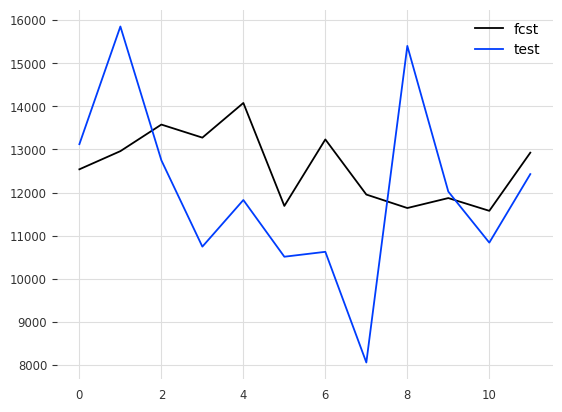

In [20]:
input_chunck_length=24
n_epochs=10
d_model=64
nhead=4
num_encoder_layers=4
num_decoder_layers=3

# Specifying a model using the gridsearch parameters
model = TransformerModel(
    input_chunk_length=input_chunck_length,
    output_chunk_length=12,
    n_epochs=n_epochs,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    random_state=123
)

# Train the model
model.fit(
    train_scaled,
    
    # add the promotions as past covariates
    past_covariates=promos_train
)


# Forecast 12 steps using this model
fcst = model.predict(
    n=12,

    # add past covariates (promos train)
    past_covariates=promos_train,
    
)

# Rescale the predictions to the original scale
fcst = my_scaler.inverse_transform(fcst).values()

# Compute metric
metric = 1 - mean_absolute_percentage_error(list(test['SALES']), fcst)
print(metric)

# Plot the best forecast
plt.plot(fcst)
plt.plot(list(test['SALES']))
plt.legend(['fcst', 'test'])
